In [15]:
"""
Imports we may or may not need later
"""
from qiskit import *
from qiskit import IBMQ, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit
from qiskit.algorithms import AmplificationProblem
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import plot_histogram
import math
# IBMQ.load_account()

from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere

In [16]:
"""
This cell contains functions stolen from Qiskit handbook.
"""
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [17]:
"""
This cell includes many helper functions we created.
"""

def construct_full_grovers(num_grovers_iterations, n, N, M):
    T_regs = QuantumRegister(N, name = "t_reg")
    P_regs = QuantumRegister(M, name = "p_reg")
    k_regs = QuantumRegister(n, name = "k_reg")
    qc = QuantumCircuit(k_regs, T_regs, P_regs, name=f"Grovers {num_grovers_iterations} times")
    
    # (1) cyclic shift (2) XOR's (3) oracle (4) diffusion operator
    relevant_qubits = []
    for i in range(n):
        relevant_qubits.append(k_regs[i])
    for i in range(N):
        relevant_qubits.append(T_regs[i])
    qc.append(cyclic_shift(n,N), relevant_qubits)
    qc.barrier()

    # (2)
    for i in range(M):
        qc.cnot(T_regs[i], P_regs[i])
    qc.barrier()

    for i in range(num_grovers_iterations):
        # (3)
        combined_qubits = [P_regs[i] for i in range(M)] + [k_regs[i] for i in range(n)]
        qc.append(construct_phase_oracle(M,n), combined_qubits)
        qc.barrier()

        # (4)
        qc.append(diffuser(M+n), combined_qubits)
        qc.barrier()
    
    return qc

def cyclic_shift(n: int, N: int):
    # easiest to implement this with registers (give up on modularity)
    T_regs = QuantumRegister(N, name = "t_reg")
    k_regs = QuantumRegister(n, name = "k_reg")
    qc = QuantumCircuit(k_regs, T_regs, name="S_k shift")
    for k in range(n):
        rotator = log_l_rotate(N, 2**k).to_gate().control(1)
        qc.append(rotator, [k_regs[k]] + [T_regs[i] for i in range(N)])
    return qc


def hadamard_index_bits(num_idx_qubits: int):
    qc = QuantumCircuit(num_idx_qubits, name="Hadamards")
    for k in range(num_idx_qubits):
        qc.h(k)
    return qc

def encode_bit_string(bit_string: str):
    n = len(bit_string)
    qc = QuantumCircuit(n, name="Encoding")
    for i in range(n):
        if bit_string[i] == "1":
            qc.x(i)
    return qc

def construct_expression(num_qubits: int,num_extras: int = 0):
    expression = '~('
    for i in range(0, num_qubits-1):
        expression += f'v{i} | '
    expression += f'v{num_qubits})'
    # this is an even more scuffed way to do these qubits
    for i in range(num_qubits+1,num_extras+num_qubits+1):
        expression += f'&(v{i} | ~v{i})'
    return expression

def construct_phase_oracle(num_qubits: int,num_extras: int = 0):
    """
    Scuffed way of calculating an oracle for ~(q0 | q1 | q2 | ...).
    There is most certainly a more general way of calculating 
    bitwise addition q0 + q1 + q2 + q3 + ...

    The advantage of this is that there is no ancilla qubit to worry about and uncompute.
    """
    oracle = PhaseOracle(expression=construct_expression(num_qubits,num_extras))
    return oracle

def rotation_ending_position(value,size,times):
    """
    Returns the ending position of a given index in the array
    """
    return (value - times) % size

def is_list_shifted(lst,times):
    size = len(lst)
    for i in range(size):
        if(i != rotation_ending_position(lst[i],size,times)):
            # print(lst[i],rotation_ending_position(i,size,times))
            return False
    return True

def log_l_rotate(count,times):
    """
    Computes swap gate sequence necessary to create cyclic krotation in logarithmic time.
    
    rotates system from startRange to endRange time times if kbit is 1
    """
    qc = QuantumCircuit(count, name=f"S_{times}")
    numIterations = 0 # ensure logarithmic time dependence. returned at end
    vals = list(range(count)) # create an ordered list to help keep track of which gates have already been swapped into their correct position
    size = len(vals)
    while not is_list_shifted(vals,times):
        numIterations+=1
        vals_added = [] # all the values which we have already swapped, used to not double count the number of gates per iteration
        for i in range(size):
            # skip any cells which we are swapping this iteration, we can't use them!
            # note that this means we need to add the indices of each cell we are swapping
            if i in vals_added:
                continue
            preferred_location = rotation_ending_position(vals[i],size,times)
            # traverse all the values. If the gate hasn't already been swapped to its desired postion,
            # add a swap circuit and swap the two values
            if(i!=preferred_location):
                qc.swap(i,preferred_location)
                vals_added.append(i)
                vals_added.append(preferred_location)
                vals[preferred_location],vals[i] = vals[i],vals[preferred_location]
    return qc


In [18]:
"""
This and the following cells contain our steps for the circuit
"""

T = '0110'
P = '10'
num_answers = 1

N = len(T)
M = len(P)
n = math.ceil(math.log(N,2))
num_grovers_iterations = math.floor(math.sqrt(N/num_answers))# ceil or floor?

# construct registers
k_regs = QuantumRegister(n, name = "k_reg") # index
T_regs = QuantumRegister(N, name = "t_reg") # text
P_regs = QuantumRegister(M, name = "p_reg") # pattern

cout = ClassicalRegister(n, "idx_cout")

# order is important - always k then T then P
main_qc = QuantumCircuit(k_regs, T_regs, P_regs, cout)

main_qc.append(encode_bit_string(T), T_regs)
main_qc.append(encode_bit_string(P), P_regs)
main_qc.append(hadamard_index_bits(n), k_regs)
main_qc.barrier()

main_qc.append(construct_full_grovers(num_grovers_iterations, n, N, M), [i for i in range(n+N+M)])
main_qc.barrier()

main_qc.measure(k_regs, cout)

main_qc.draw()


┌────────────┐ ░ ┌──────────────────┐ ░ ┌─┐   
   k_reg_0: ┤0           ├─░─┤0                 ├─░─┤M├───
            │  Hadamards │ ░ │                  │ ░ └╥┘┌─┐
   k_reg_1: ┤1           ├─░─┤1                 ├─░──╫─┤M├
            ├───────────┬┘ ░ │                  │ ░  ║ └╥┘
   t_reg_0: ┤0          ├──░─┤2                 ├─░──╫──╫─
            │           │  ░ │                  │ ░  ║  ║ 
   t_reg_1: ┤1          ├──░─┤3                 ├─░──╫──╫─
            │  Encoding │  ░ │  Grovers 2 times │ ░  ║  ║ 
   t_reg_2: ┤2          ├──░─┤4                 ├─░──╫──╫─
            │           │  ░ │                  │ ░  ║  ║ 
   t_reg_3: ┤3          ├──░─┤5                 ├─░──╫──╫─
            ├───────────┤  ░ │                  │ ░  ║  ║ 
   p_reg_0: ┤0          ├──░─┤6                 ├─░──╫──╫─
            │  Encoding │  ░ │                  │ ░  ║  ║ 
   p_reg_1: ┤1          ├──░─┤7                 ├─░──╫──╫─
            └───────────┘  ░ └──────────────────┘ ░  ║  ║ 
idx_cout_0: ═════════════════════════════════════════╩══╬═
                                                        ║ 
idx_cout_1: ════════════════════════════════════════════╩═

The measured counts for T='0110', P='10'. Notice how 3 (little endian) is the lowest state


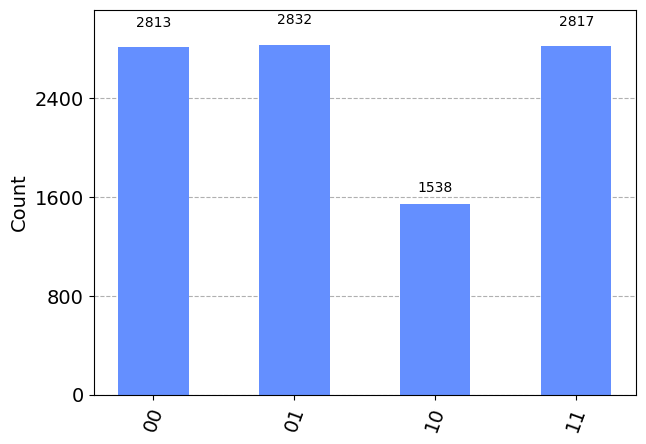

In [25]:
sim = Aer.get_backend('aer_simulator')
circ_transpiled = transpile(main_qc, sim)
qobj = assemble(circ_transpiled)
job = sim.run(qobj, shots = 10000)
results = job.result()
answer = results.get_counts()
print(f"The measured counts for T='{T}', P='{P}'. Notice how 3 (little endian) is the lowest state")
plot_histogram(answer)

In [6]:
main_qc.draw()

┌────────────┐ ░ ┌──────────────────┐ ░ ┌─┐   
   k_reg_0: ┤0           ├─░─┤0                 ├─░─┤M├───
            │  Hadamards │ ░ │                  │ ░ └╥┘┌─┐
   k_reg_1: ┤1           ├─░─┤1                 ├─░──╫─┤M├
            ├───────────┬┘ ░ │                  │ ░  ║ └╥┘
   t_reg_0: ┤0          ├──░─┤2                 ├─░──╫──╫─
            │           │  ░ │                  │ ░  ║  ║ 
   t_reg_1: ┤1          ├──░─┤3                 ├─░──╫──╫─
            │  Encoding │  ░ │  Grovers 2 times │ ░  ║  ║ 
   t_reg_2: ┤2          ├──░─┤4                 ├─░──╫──╫─
            │           │  ░ │                  │ ░  ║  ║ 
   t_reg_3: ┤3          ├──░─┤5                 ├─░──╫──╫─
            ├───────────┤  ░ │                  │ ░  ║  ║ 
   p_reg_0: ┤0          ├──░─┤6                 ├─░──╫──╫─
            │  Encoding │  ░ │                  │ ░  ║  ║ 
   p_reg_1: ┤1          ├──░─┤7                 ├─░──╫──╫─
            └───────────┘  ░ └──────────────────┘ ░  ║  ║ 
idx_cout_0: ═════════════════════════════════════════╩══╬═
                                                        ║ 
idx_cout_1: ════════════════════════════════════════════╩═

In [7]:
main_qc.decompose().draw()

┌───┐ ░ ┌────────────┐ ░            ░ ┌───────────────┐ ░ »
   k_reg_0: ┤ H ├─░─┤0           ├─░────────────░─┤2              ├─░─»
            ├───┤ ░ │            │ ░            ░ │               │ ░ »
   k_reg_1: ┤ H ├─░─┤1           ├─░────────────░─┤3              ├─░─»
            └───┘ ░ │            │ ░            ░ │               │ ░ »
   t_reg_0: ──────░─┤2           ├─░───■────────░─┤               ├─░─»
            ┌───┐ ░ │  S_k shift │ ░   │        ░ │               │ ░ »
   t_reg_1: ┤ X ├─░─┤3           ├─░───┼────■───░─┤               ├─░─»
            ├───┤ ░ │            │ ░   │    │   ░ │  Phase Oracle │ ░ »
   t_reg_2: ┤ X ├─░─┤4           ├─░───┼────┼───░─┤               ├─░─»
            └───┘ ░ │            │ ░   │    │   ░ │               │ ░ »
   t_reg_3: ──────░─┤5           ├─░───┼────┼───░─┤               ├─░─»
            ┌───┐ ░ └────────────┘ ░ ┌─┴─┐  │   ░ │               │ ░ »
   p_reg_0: ┤ X ├─░────────────────░─┤ X ├──┼───░─┤0              ├─░─»
            └───┘ ░                ░ └───┘┌─┴─┐ ░ │               │ ░ »
   p_reg_1: ──────░────────────────░──────┤ X ├─░─┤1              ├─░─»
                  ░                ░      └───┘ ░ └───────────────┘ ░ »
idx_cout_0: ══════════════════════════════════════════════════════════»
                                                                      »
idx_cout_1: ══════════════════════════════════════════════════════════»
                                                                      »
«            ┌────────┐ ░ ┌───────────────┐ ░ ┌────────┐ ░  ░ ┌─┐   
«   k_reg_0: ┤2       ├─░─┤2              ├─░─┤2       ├─░──░─┤M├───
«            │        │ ░ │               │ ░ │        │ ░  ░ └╥┘┌─┐
«   k_reg_1: ┤3       ├─░─┤3              ├─░─┤3       ├─░──░──╫─┤M├
«            │        │ ░ │               │ ░ │        │ ░  ░  ║ └╥┘
«   t_reg_0: ┤        ├─░─┤               ├─░─┤        ├─░──░──╫──╫─
«            │        │ ░ │               │ ░ │        │ ░  ░  ║  ║ 
«   t_reg_1: ┤        ├─░─┤               ├─░─┤        ├─░──░──╫──╫─
«            │  U$_s$ │ ░ │  Phase Oracle │ ░ │  U$_s$ │ ░  ░  ║  ║ 
«   t_reg_2: ┤        ├─░─┤               ├─░─┤        ├─░──░──╫──╫─
«            │        │ ░ │               │ ░ │        │ ░  ░  ║  ║ 
«   t_reg_3: ┤        ├─░─┤               ├─░─┤        ├─░──░──╫──╫─
«            │        │ ░ │               │ ░ │        │ ░  ░  ║  ║ 
«   p_reg_0: ┤0       ├─░─┤0              ├─░─┤0       ├─░──░──╫──╫─
«            │        │ ░ │               │ ░ │        │ ░  ░  ║  ║ 
«   p_reg_1: ┤1       ├─░─┤1              ├─░─┤1       ├─░──░──╫──╫─
«            └────────┘ ░ └───────────────┘ ░ └────────┘ ░  ░  ║  ║ 
«idx_cout_0: ══════════════════════════════════════════════════╩══╬═
«                                                                 ║ 
«idx_cout_1: ═════════════════════════════════════════════════════╩═
«

In [8]:
main_qc.decompose().decompose().draw()

┌─────────┐  ░                  ░            ░               ░ »
   k_reg_0: ─┤ U2(0,π) ├──░────■─────────────░────────────░───────────────░─»
             ├─────────┤  ░    │             ░            ░               ░ »
   k_reg_1: ─┤ U2(0,π) ├──░────┼───────■─────░────────────░───────────────░─»
             └─────────┘  ░ ┌──┴───┐┌──┴───┐ ░            ░               ░ »
   t_reg_0: ──────────────░─┤0     ├┤0     ├─░───■────────░───────────────░─»
            ┌───────────┐ ░ │      ││      │ ░   │        ░               ░ »
   t_reg_1: ┤ U3(π,0,π) ├─░─┤1     ├┤1     ├─░───┼────■───░───────────────░─»
            ├───────────┤ ░ │  S_1 ││  S_2 │ ░   │    │   ░               ░ »
   t_reg_2: ┤ U3(π,0,π) ├─░─┤2     ├┤2     ├─░───┼────┼───░───────────────░─»
            └───────────┘ ░ │      ││      │ ░   │    │   ░               ░ »
   t_reg_3: ──────────────░─┤3     ├┤3     ├─░───┼────┼───░───────────────░─»
            ┌───────────┐ ░ └──────┘└──────┘ ░ ┌─┴─┐  │   ░               ░ »
   p_reg_0: ┤ U3(π,0,π) ├─░──────────────────░─┤ X ├──┼───░───────o───────░─»
            └───────────┘ ░                  ░ └───┘┌─┴─┐ ░ ┌───┐ │ ┌───┐ ░ »
   p_reg_1: ──────────────░──────────────────░──────┤ X ├─░─┤ X ├─■─┤ X ├─░─»
                          ░                  ░      └───┘ ░ └───┘   └───┘ ░ »
idx_cout_0: ════════════════════════════════════════════════════════════════»
                                                                            »
idx_cout_1: ════════════════════════════════════════════════════════════════»
                                                                            »
«            ┌───┐┌───┐          ┌───┐┌───┐      ░               ░ ┌───┐┌───┐»
«   k_reg_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░───────────────░─┤ H ├┤ X ├»
«            ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░               ░ ├───┤├───┤»
«   k_reg_1: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░───────────────░─┤ H ├┤ X ├»
«            └───┘└───┘└───┘└─┬─┘└───┘└───┘└───┘ ░               ░ └───┘└───┘»
«   t_reg_0: ─────────────────┼──────────────────░───────────────░───────────»
«                             │                  ░               ░           »
«   t_reg_1: ─────────────────┼──────────────────░───────────────░───────────»
«                             │                  ░               ░           »
«   t_reg_2: ─────────────────┼──────────────────░───────────────░───────────»
«                             │                  ░               ░           »
«   t_reg_3: ─────────────────┼──────────────────░───────────────░───────────»
«            ┌───┐┌───┐       │  ┌───┐┌───┐      ░               ░ ┌───┐┌───┐»
«   p_reg_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░───────o───────░─┤ H ├┤ X ├»
«            ├───┤├───┤       │  ├───┤├───┤      ░ ┌───┐ │ ┌───┐ ░ ├───┤├───┤»
«   p_reg_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤ X ├─■─┤ X ├─░─┤ H ├┤ X ├»
«            └───┘└───┘          └───┘└───┘      ░ └───┘   └───┘ ░ └───┘└───┘»
«idx_cout_0: ════════════════════════════════════════════════════════════════»
«                                                                            »
«idx_cout_1: ════════════════════════════════════════════════════════════════»
«                                                                            »
«                      ┌───┐┌───┐      ░  ░ ┌─┐   
«   k_reg_0: ───────■──┤ X ├┤ H ├──────░──░─┤M├───
«            ┌───┐┌─┴─┐├───┤├───┤┌───┐ ░  ░ └╥┘┌─┐
«   k_reg_1: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──░──╫─┤M├
«            └───┘└─┬─┘└───┘└───┘└───┘ ░  ░  ║ └╥┘
«   t_reg_0: ───────┼──────────────────░──░──╫──╫─
«                   │                  ░  ░  ║  ║ 
«   t_reg_1: ───────┼──────────────────░──░──╫──╫─
«                   │                  ░  ░  ║  ║ 
«   t_reg_2: ───────┼──────────────────░──░──╫──╫─
«                   │                  ░  ░  ║  ║ 
«   t_reg_3: ───────┼──────────────────░──░──╫──╫─
«                   │  ┌───┐┌───┐      ░  ░  ║  ║ 
«   p_reg_0: ───────■──┤ X ├┤ H ├──────░──░──╫──╫─
« 

In [21]:
"""
Finally, our pattern matching function is complete. This combines everything into one black box function. 
Unfortunately, this function only works for a single solution meaning there can be at most one pattern P in the string T. The behavior otherwise is undefined. 
"""
def q_pattern_matching_single_sol(T: str, P: str):
    """
    Takes parameters T for text. P for pattern. 
    Returns the start index of P in T using a simulated quantum algorithm.
    There are several conditions T and P must follow.
        - Both need to be bitwise strings. 
        - Log base 2 of length(T) must be an integer
        - There must be only one solution
        - 1 < length(P) <= length(T)
        - T and P must not be too large or we cannot simulate it
    """
    num_answers = 1

    N = len(T)
    M = len(P)
    n = math.ceil(math.log(N,2))
    num_grovers_iterations = math.floor(math.sqrt(N/num_answers))

    # construct registers
    k_regs = QuantumRegister(n, name = "k_reg") # index
    T_regs = QuantumRegister(N, name = "t_reg") # text
    P_regs = QuantumRegister(M, name = "p_reg") # pattern

    cout = ClassicalRegister(n, "idx_cout")

    # order is important - always k then T then P
    main_qc = QuantumCircuit(k_regs, T_regs, P_regs, cout)

    main_qc.append(encode_bit_string(T), T_regs)
    main_qc.append(encode_bit_string(P), P_regs)
    main_qc.append(hadamard_index_bits(n), k_regs)
    main_qc.barrier()

    main_qc.append(construct_full_grovers(num_grovers_iterations, n, N, M), [i for i in range(n+N+M)])
    main_qc.barrier()

    main_qc.measure(k_regs, cout)
    # run circuit
    sim = Aer.get_backend('aer_simulator')
    circ_transpiled = transpile(main_qc, sim)
    qobj = assemble(circ_transpiled)
    job = sim.run(qobj, shots = 1000000)
    results = job.result()
    answer = results.get_counts()

    min_state = ''
    min_count = 10000000000000 # infinity
    for state, count in answer.items():
        if count < min_count:
            min_state = state
            min_count = count
    
    # convert binary string to int
    return int(min_state, 2) # cast with base 2

In [22]:
print("Run some test cases (this might take a while)....")
assert q_pattern_matching_single_sol("0111", "01") == 0
assert q_pattern_matching_single_sol("0111", "111") == 1
assert q_pattern_matching_single_sol("0110", "10") == 2

# most of the time this passes, every time
assert q_pattern_matching_single_sol("11100110", "0110") == 4
assert q_pattern_matching_single_sol("11101111", "01") == 3
assert q_pattern_matching_single_sol("11101111", "01111") == 3
assert q_pattern_matching_single_sol("00000001", "01") == 6
assert q_pattern_matching_single_sol("00000001", "00000001") == 0
print("All tests passed!")

Run some test cases (this might take a while)....
All tests passed!
